In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix

from scipy.sparse import diags
from scipy.sparse.linalg import cg


%pylab inline
import pylab

Populating the interactive namespace from numpy and matplotlib


# Stereo Matching

In [2]:
def scale_img(img):
    '''
    Explanation:
        - A utility function to convert image values to [0, 255] range
        
    :param img: numpy.ndarray 
                    -image that we have to scale
    
    :return: numpy.ndarray
                    -output scaled image to range [0, 255]
    '''    
    out_img = ((img - np.min(img)) / (np.max(img) - np.min(img)))*255
    
    return out_img.astype('uint8')

In [3]:
def stereo_match(stereo_params):
    '''
    Explanation:
        - Performs stereo matching between a rectified stereo pair
    
    :param stereo_params: list -> A list containing 4 params, i.e: 
            - string - left image name
            - string - right image name
            - int - scale percent (For scaling down images)
            - int - Maximum possible dispairity value
    
    :return: numpy.ndarray
                -ref -> left image (It will be treated as reference throughout)
    :return: numpy.ndarray
                -conf -> confidence in each disparity calculated
    :return: numpy.ndarray
                - depth -> disparity an each point (Note: actual depth has inverse relation with disparity) 
    '''
    
    limg_name, rimg_name, scale_percent, max_d = stereo_params
    limg = cv2.imread('../images/' + limg_name)
    limg = cv2.cvtColor(limg, cv2.COLOR_BGR2RGB)
    rimg = cv2.imread('../images/' + rimg_name)
    ref = np.copy(limg)
    H, W, _ = limg.shape 

    Ws = int(limg.shape[1] * scale_percent / 100)
    Hs = int(limg.shape[0] * scale_percent / 100)

    # resize images
    limg = cv2.resize(limg, (Ws, Hs), interpolation = cv2.INTER_AREA)
    rimg = cv2.resize(rimg, (Ws, Hs), interpolation = cv2.INTER_AREA)

    assert limg.shape == rimg.shape, 'Different Shapes!'

    min_d = 0
    disparity = np.ones((Hs, Ws, max_d - min_d)).astype('int64')
    min_diff_img = np.zeros((Hs, Ws)) # Opposite of confidence
    min_disp_img = np.zeros((Hs, Ws))

    for i in range(Hs):
        for j in range(Ws):
            min_diff = 1e+7
            min_idx = 0
            for d in range(max_d - min_d):
                if (j - d) < 0:
                    disparity[i][j][d] = 1e+7
                else:
                    disparity[i][j][d] = np.mean((limg[i,j,:] - rimg[i,j-d, :])**2)
                    if disparity[i][j][d] < min_diff:
                        min_diff = disparity[i][j][d]
                        min_idx = d
            
            min_diff_img[i][j] = min_diff
            min_disp_img[i][j] = min_idx


    conf = scale_img(1 / (min_diff_img+1))
    depth = scale_img(min_disp_img) # should be  reciprocal?

    conf = cv2.resize(conf, (W, H), interpolation = cv2.INTER_AREA)
    depth = cv2.resize(depth, (W, H), interpolation = cv2.INTER_AREA)

    return ref, conf, depth

# Bilateral Grid

In [4]:
 class BilateralHelper:
    '''
    Explanation:
        - Helpler class for bilateral grid
        - This class implements helper function necessary for grid creation
    '''

    def get_coords(self, im,  sigma_spatial=32, sigma_luma=8, sigma_chroma=8):
        '''
        Explanation:
            -Maps each pixel of the color image to a 5-dimensional space (x, y, Y, Cr, Cb)
            
        :param im: numpy.ndarray 
                    -image that has to be converted to 5-dimensional space
        :param sigma_spatial: int
                                -sigma value for bilateral of x, y
        :param sigma_luna: int
                            -sigma value for bilateral of Y
        :param sigma_chroma: int
                                -sigma value for bilateral of Cr, Cb
        
        :return: numpy.ndarray
                    -coords -> coordinates in 5 dimension.
        '''
        
        im_yCrCb = cv2.cvtColor(im, cv2.COLOR_RGB2YCrCb)

        # x_grid, y_grid has same shape (W, H) as input image
        y_grid, x_grid = np.mgrid[:im.shape[0], :im.shape[1]]

        # Spatial Coordinates
        coords_x = (x_grid / sigma_spatial).astype(int)
        coords_y = (y_grid / sigma_spatial).astype(int)

        # Luma Coordinates
        coords_luma = (im_yCrCb[:,:, 0] /sigma_luma).astype(int)

        # Chroma Coordinates
        coords_Cr = (im_yCrCb[:,:, 1] /sigma_chroma).astype(int)

        # Chroma Coordinates
        coords_Cb = (im_yCrCb[:,:, 2] /sigma_chroma).astype(int)

        # 5 Dimensional Coordinates
        coords = np.dstack((coords_x, coords_y, coords_luma, coords_Cr, coords_Cb))

        # Flattening the cordinates
        # Here no of rows = (WxH), i.e: no of pixels
        # no of cols = 5, i.e: (x, y, luma, cr, cb)
        coords = coords.reshape(-1, coords.shape[-1])

        return coords


    def get_hash_coords(self, ndim, coords, hashvec):
        '''
        Explanation:
            - Apply hashing to get unique coordinates from 5-dimensional coordinate space.
            - These unique coordinates represent vertices in the image.
            
        :param ndim: int
                    -Number of dimensions
        :param coords: numpy.ndarray
                    -Coordinates in 5 dimension
        :param hashvec: numpy.ndarray
                    -Hash vector
        
        :return: numpy.ndarray
                    -hashcoords -> hashcoordinates obtained from 5 dimensional coordinates and hash vector
                    
        :return: numpy.ndarray
                    -hash_uniq -> Unique hash coordinates (representing vertices in the image)
        
        :return: numpy.ndarray
                    -idx_uniq -> Index of unique hash coordinates
                    
        :return: numpy.ndarray
                    -idx_inv -> idx_uniq in reverse order
                    
        :return: numpy.ndarray
                    -uniqcoords -> unique coordinates in 5 dimentional space
        '''
        
        hashcoords = coords @ hashvec
        
        # print('HashVec: ', hashvec)
        # print('Coords Shape, Hash Coords Shape: ', coords.shape, hashcoords.shape)

        # hash_uniq: the unique hashes
        # idx_uniq: indices of unique hashed in original array
        # idx_inv: can be used to create original array from hash_uniq
        hash_uniq, idx_uniq, idx_inv =  np.unique(hashcoords, return_index=True, return_inverse=True)

        # Getting unique pixels (This represents vertices)
        uniqcoords = coords[idx_uniq]
        assert hash_uniq.shape[0] == uniqcoords.shape[0], 'No of uniq hashes and no of uniq cords dont match!'

        return hashcoords, hash_uniq, idx_uniq, idx_inv, uniqcoords


    def get_blur_matrices(self, hashvec, uniqcoords, hash_uniq, nvertices, ndim):
        '''
        Explanation:
            -Creates Blur Matirces
            -Number of Blur Matrices = number of dimensions (in our case, 5)
        
        :param hashvec: numpy.ndarray
                    -Hash vector
                    
        :param uniqcoords: numpy.ndarray
                    -Unique coordinates in 5 dimentional space (Vertices)
                    
        :param hash_uniq: numpy.ndarray
                    -Unique hash coordinates (representing vertices in the image)
                    
        :param nvertices: int
                    -Number of vertices
                    
        :param ndim: int
                    -Number of dimensions
        '''
        
        def get_valid_idx(valid, candidates):
            '''
            Explanation:
                - Find which values are present in a list and where they are located
                
            :param valid: numpy.ndarray
                            - Array of valid coordinates
            
            :param candidates: numpy.ndarray
                            - Array of candidates
            
            :return: numpy.ndarray
                        - valid_idx: Array of valid candidates
                
            :return: numpy.ndarray
                        - locs: location of the valid candidates
            
            '''
            
            # This is just a helper function for creating blur matrices
            locs = np.searchsorted(valid, candidates)
            
            # Handle edge case where the candidate is larger than all valid values
            locs = np.clip(locs, 0, len(valid) - 1)
            
            # Identify which values are actually present
            valid_idx = np.flatnonzero(valid[locs] == candidates)
            locs = locs[valid_idx] 
            return valid_idx, locs
        
        blurs = []
        for d in range(ndim):
            blur = 0
            for offset in (-1, 1):
                offsetvec = np.zeros((1, ndim))
                offsetvec[:, d] = offset
                hash_neighbor = (uniqcoords + offsetvec) @ hashvec
                valid_coord, idx = get_valid_idx(hash_uniq, hash_neighbor)
                blur = blur + csr_matrix((np.ones((len(valid_coord),)),
                                            (valid_coord, idx)),
                                            shape=(nvertices, nvertices))
            blurs.append(blur)

        return blurs

In [5]:
class BilateralGrid(BilateralHelper):
    '''
    Explanation:
        - Extends BilateralHelper class
        - Generates Blur, Slice and Splat matrices
        - Implements methods to apply bilateral filter on an image 
    '''

    def __init__(self, im, sigma_spatial=32, sigma_luma=8, sigma_chroma=8):
        '''
        Explanation:
            - Constructor of the class
        
        :param im: numpy.ndarray 
                    -image that has to be converted to 5-dimensional space
        :param sigma_spatial: int
                                -sigma value for bilateral of x, y
        :param sigma_luna: int
                            -sigma value for bilateral of Y
        :param sigma_chroma: int
                                -sigma value for bilateral of Cr, Cb 
        '''
        
        # Getting 5 dimensional coordinates(npixels x 5)
        coords = self.get_coords(im)
        self.npixels, self.ndim = coords.shape
        print('Number of pixels, dims: ', self.npixels, self.ndim)


        # Creating the hash vector
        hashvec = (255 ** np.arange(self.ndim))
        
        # Hashing the cords
        hashcoords, hash_uniq, idx_uniq, idx_inv, uniqcoords = self.get_hash_coords(self.ndim, coords, hashvec)
        self.nvertices = uniqcoords.shape[0]
        print('Number of vertices: ', self.nvertices)

        # Constructing the sparse Splat matrix to go from pixel -> vertices
        self.S = csr_matrix((np.ones(self.npixels), (idx_inv, np.arange(self.npixels))))
        print('Splat Matrix Shape: ', self.S.shape)

        # Generating The Blur Matrices
        self.blurs = self.get_blur_matrices(hashvec, uniqcoords, hash_uniq, self.nvertices, self.ndim)

    
    def blur(self, x):
        '''
        Explanation:
            - Blur in bilateral domain with a 1 2 1 filter for each dim
            
        :param x: numpy.ndarray
                    -Input array
        '''
        blur_output = 2 * self.ndim * x
        for blur in self.blurs:
            blur_output += blur @ x
        return blur_output


    def splat(self, x):
        '''
        Explanation:
            - Applies splat on the input
            
        :param x: numpy.ndarray
                    -input array
        '''
        return self.S @ x


    def slice(self, x):
        '''
        Explanation:
            - Apply Slice on the input
            
        :param x: numpy.ndarray
                    -input array
        '''
        return self.S.T @ x


    def apply_filter(self, x):
        '''
        Explanation:
            - This function applies the created bilateral filter to the given input
            
        :param x: numpy.ndarray
                    -input grid
                    
        :return: numpy.ndarray
                    - Output after applying the bilteral filter
        '''
        out = (self.S.T @ self.blur(self.S @ x) )
        out = out / (self.S.T @ self.blur(self.S @ np.ones_like(x)))
        return out

# Bilateral Solver

In [6]:
def get_bistochastize(grid, iterations=10):
    '''
    Explanation:
       - Compute diagonal matrices to bistochastize a bilateral grid
       - Bistochastize matrix is the one in which the rows and columns sum to one
       
    :param grid: numpy.ndarray
                    - Bilateral Grid generated by BilateralGrid Class
    
    :param maxiter: int
                    - Maximum number of iterations
                    
    :return: numpy.ndarray
                    - Diag_n : Sparse matrix
                    
    :return: numpy.ndarray
                    - Diag_m : Sparse matrix
    '''
    m = grid.splat(np.ones(grid.npixels))
    n = np.ones(grid.nvertices)
    for i in range(iterations):
        n = np.sqrt(n * m / grid.blur(n))
    m = n * grid.blur(n)
    Diag_m = diags(m, 0)
    Diag_n = diags(n, 0)

    return Diag_n, Diag_m

class BilateralSolver(object):
    '''
    Explanation:
        - Fast edge-aware stereo algorithm
    '''
    
    def __init__(self, grid, solver_params):
        '''
        Explanation:
            - Constructor of the class
            
        :param grid: numpy.ndarray
                        - Bilateral grid
                        
        :param params: list
                        - list of the solver params
                        [
                            int - The strength of the smoothness parameter,
                            float - Clamp the diagonal of the A diagonal in the Jacobi preconditioner,
                            float - The tolerance on the convergence in PCG,
                            int - The number of PCG iterations 
                        ]

        '''
        self.grid = grid
        self.params = solver_params
        self.Dn, self.Dm = get_bistochastize(grid)
    
    
    def solve(self, X, W):
        '''
        Explanation:
            - Solves for depth in bilateral space
            
        :param x: numpy.ndarray
                    - Depth Initialization
                    
        :param w: numpy.ndarray
                    - Confidence
        '''
        
        if W.ndim == 2:
            assert(W.shape[1] == 1)
        elif W.dim == 1:
            W = W.reshape(W.shape[0], 1)

        A_smooth = (self.Dm - self.Dn.dot(self.grid.blur(self.Dn)))
        W_splat = self.grid.splat(W)+1
        A_data = diags(W_splat[:,0], 0)
        A = self.params["lam"] * A_smooth + A_data
        XW = X * W
        b = self.grid.splat(XW)
        A_diag = np.maximum(A.diagonal(), self.params["A_diag_min"])
        M = diags(1 / A_diag, 0)
        y0 = self.grid.splat(XW) / W_splat
        yhat = np.empty_like(y0)
        for d in range(X.shape[-1]):
            # Using Scipy solver
            yhat[..., d], info = cg(A, b[..., d], x0=y0[..., d], M=M, maxiter=self.params["cg_maxiter"], tol=self.params["cg_tol"])
        Xhat = self.grid.slice(yhat)
        return Xhat

# Blur Effect Using Depth Image

In [7]:
def stereo_blur(depth, ref, limit_L, limit_U):
    '''
    Explanation:
        - Gets blured (defocused image) using depth map
        
    :param depth: numpy.ndarray
                    - Depth map generated using the stereo pair
                    
    :param ref: numpy.ndarray
                    - Reference Image
                    
    :param limit_L: numpy.ndarray
                    - Lower limit of depth
                    
    :param limit_U: numpy.ndarray
                    - Upper limit of depth
    '''
    depth = scale_img(depth)

    mask = np.where((depth > limit_L) & (depth < limit_U), 255, 0)
    mask = np.dstack((mask, mask, mask))

    blur = cv2.GaussianBlur(ref, (27, 27), cv2.BORDER_DEFAULT)
    blur[mask > 0] = ref[mask > 0]

    fig = plt.figure(figsize=(30,20))

    plt.subplot(1,2,1)
    plt.imshow(blur)

    plt.subplot(1,2,2)
    plt.imshow(ref)

# Results Part 1 | Getting Edge Aware Stereo

In [8]:
all_stereo_params = [
    ['pin_l.jpg', 'pin_r.jpg', 30, 32],  # Left Image, Right Image, Scale Factor, Max Disparity
    ['cones_l.png', 'cones_r.png', 30, 64],
    ['umbrella_l.bmp', 'umbrella_r.bmp', 30, 32],
    ['rabbit_l.bmp', 'rabbit_r.bmp', 30, 32],
]
solver_params = {
    'lam': 128, # This represents strength of the smoothness parameter
    'A_diag_min': 1e-5, # Used in Jacobi preconditioner.
    'cg_tol': 1e-5, # Tolerance
    'cg_maxiter': 40 # Maximum number of iterations (PCG)
}

In [9]:
def run(stereo_params, solver_params):
    '''
    Explanation:
        - Main function to apply on the stereo images
        
    :param stereo_params: list
                        - list of 4 items
                        [
                            numpy.ndarray - Left Image, 
                            numpy.ndarray - Right Image, 
                            int - Scale Factor, 
                            int - Max Disparity
                        ]
                
    :param solver_params: list
                        - list of the required parameters
                        [
                            int - The strength of the smoothness parameter,
                            float - Clamp the diagonal of the A diagonal in the Jacobi preconditioner,
                            float - The tolerance on the convergence in PCG,
                            int - The number of PCG iterations 
                        ]
    '''
    
    ref, conf, depth = stereo_match(stereo_params)
    grid = BilateralGrid(ref)

    # Normalization
    t =   depth.reshape(-1, 1).astype(double) / 255.0 # Depth is the target
    c =   conf.reshape(-1, 1).astype(double) / 255.0 # Confidence
    

    solver_output = BilateralSolver(grid, solver_params).solve(t, c).reshape(ref.shape[:2])

    # Plotting
    fig = plt.figure(figsize=(20,15))

    plt.subplot(2,2,1)
    plt.imshow(ref)
    plt.title("Reference")

    plt.subplot(2,2,2)
    plt.imshow(depth)
    plt.title('Depth')

    plt.subplot(2,2,3)
    plt.imshow(conf)
    plt.title('Confidence')

    plt.subplot(2,2,4)
    plt.imshow(solver_output, cmap='gray')
    plt.title('Bilateral Solver Output')
    return solver_output, ref

Number of pixels, dims:  141600 5
Number of vertices:  3951
Splat Matrix Shape:  (3951, 141600)


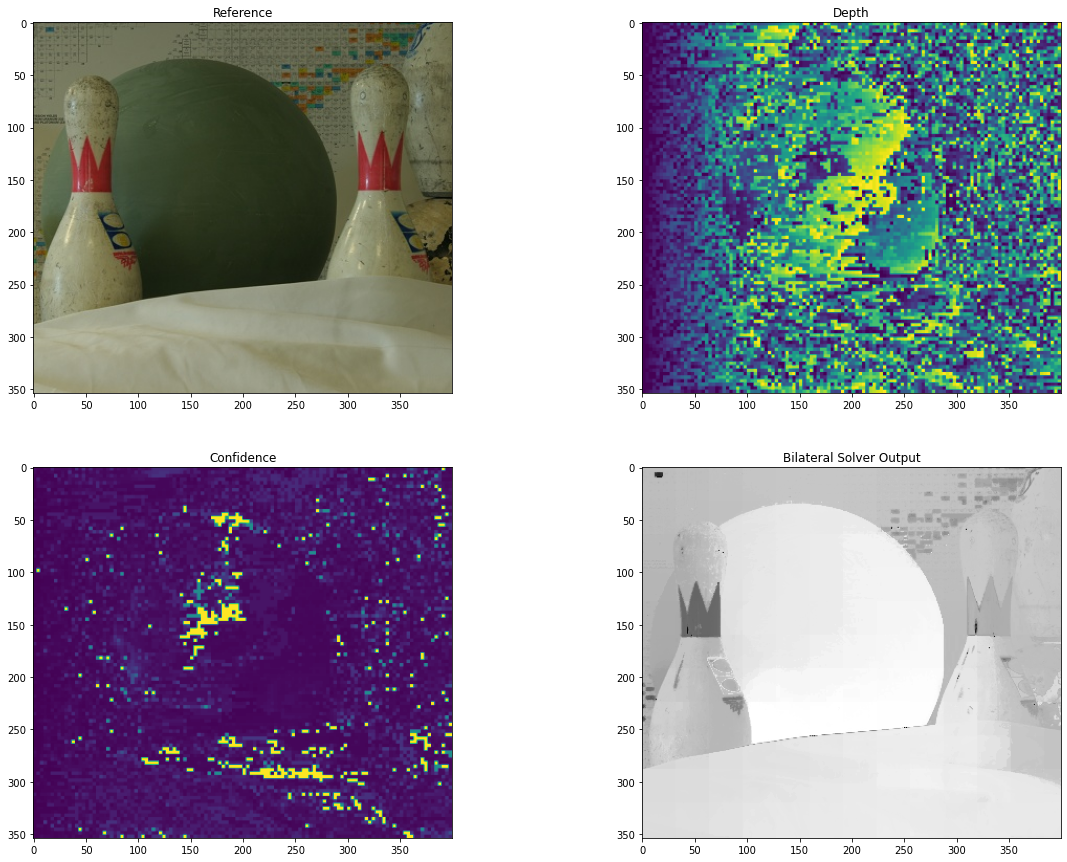

In [10]:
pin_bilateral, pin_ref = run(all_stereo_params[0], solver_params)

Number of pixels, dims:  168750 5
Number of vertices:  26481
Splat Matrix Shape:  (26481, 168750)


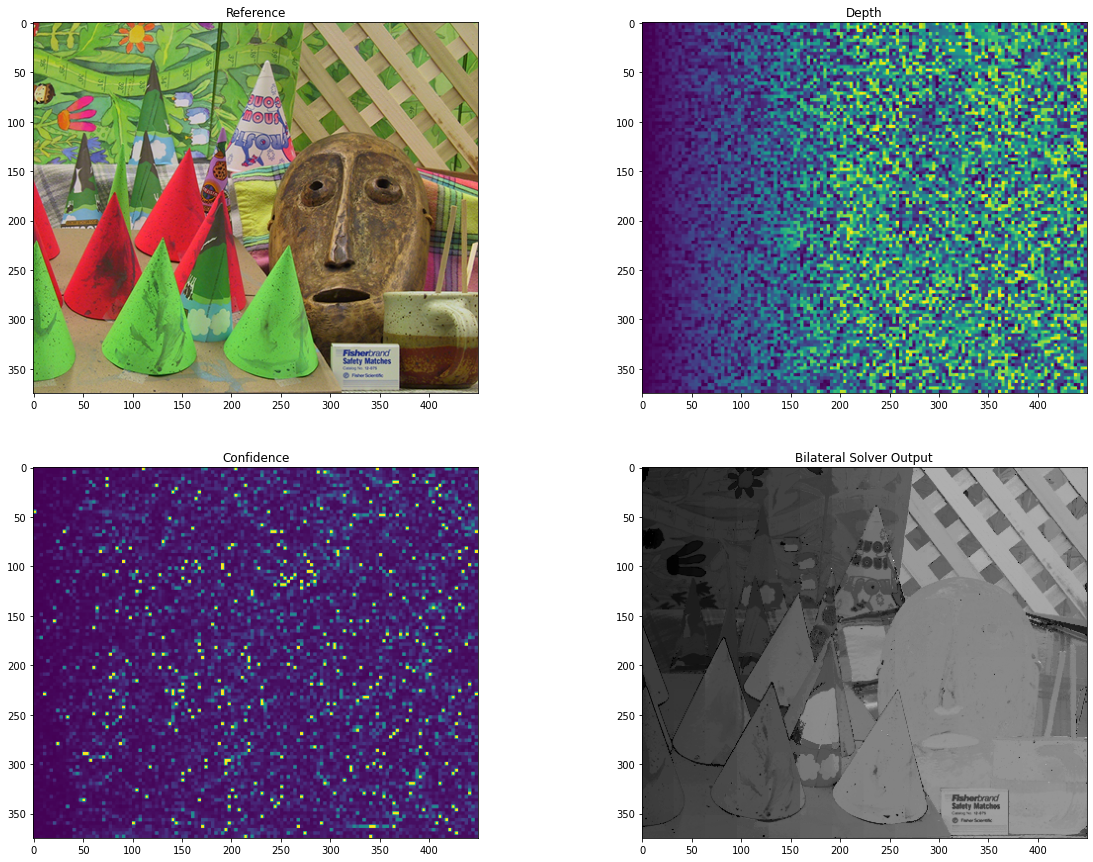

In [11]:
cones_bilateral, cones_ref = run(all_stereo_params[1], solver_params)

Number of pixels, dims:  307200 5
Number of vertices:  18702
Splat Matrix Shape:  (18702, 307200)


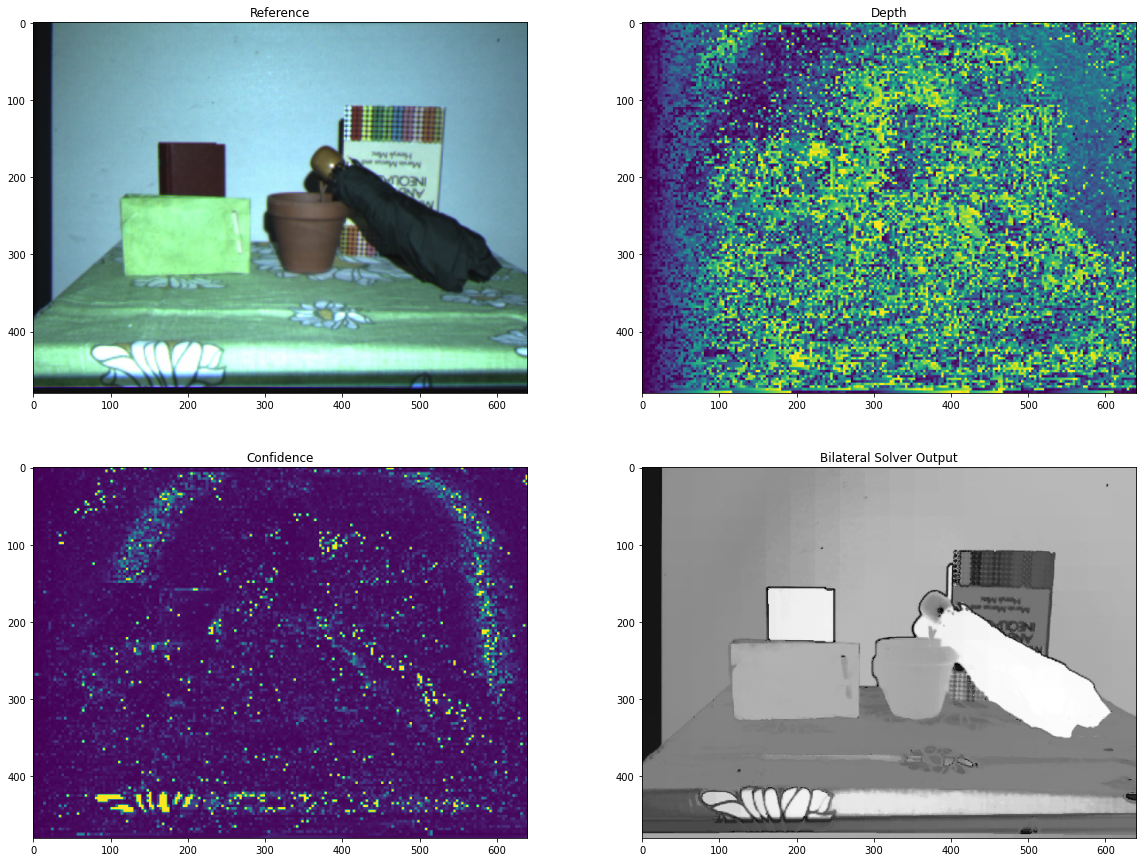

In [12]:
umbrella_bilateral, umbrella_ref = run(all_stereo_params[2], solver_params)

Number of pixels, dims:  307200 5
Number of vertices:  16849
Splat Matrix Shape:  (16849, 307200)


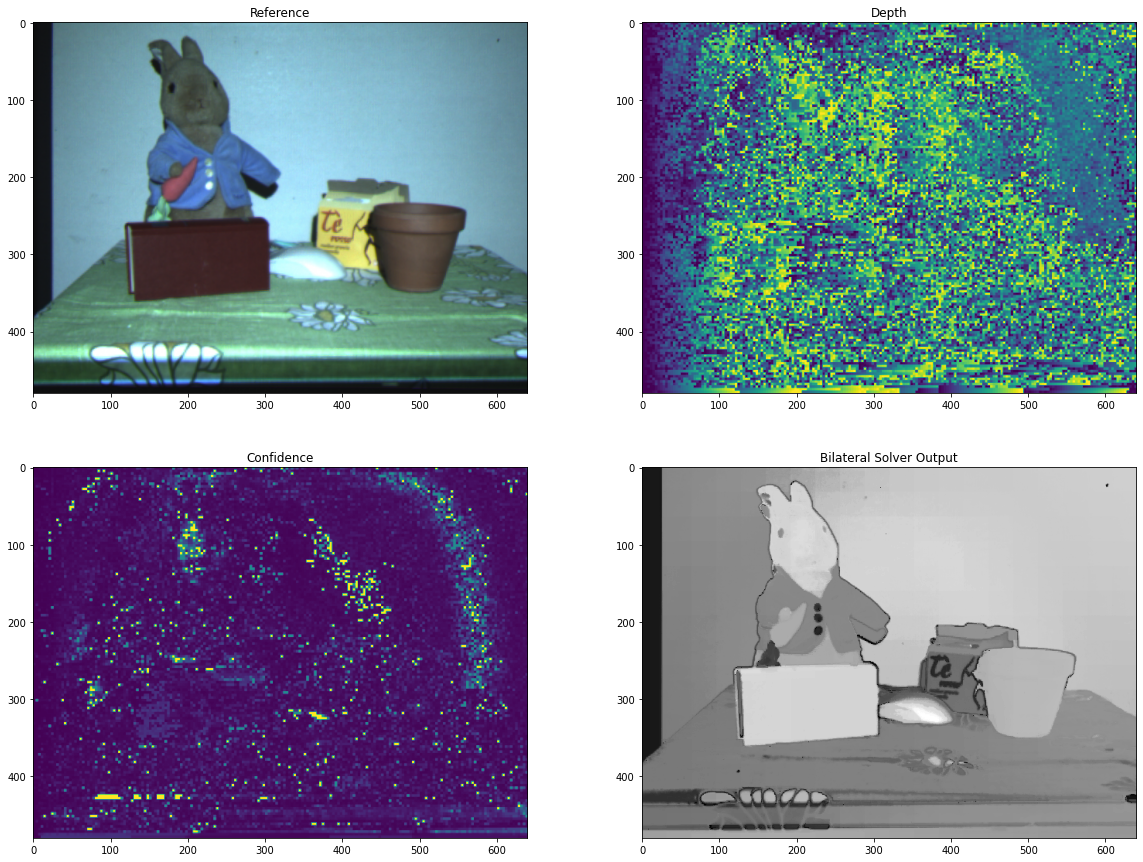

In [13]:
rabbit_bilateral, rabbit_ref = run(all_stereo_params[3], solver_params)

# Results Part 2 | Using Edge Aware Stereo To Generate Blur Effect

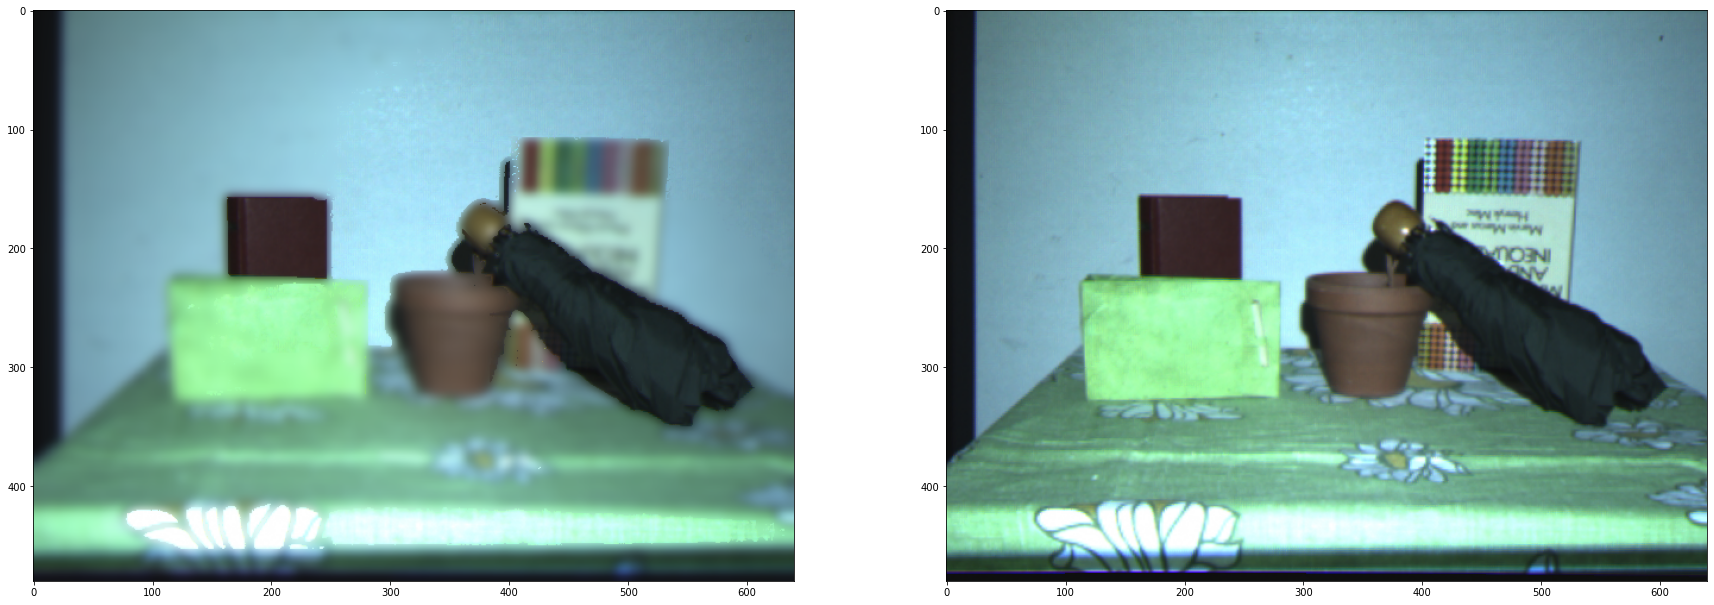

In [14]:
stereo_blur(umbrella_bilateral, umbrella_ref, 175, 255)

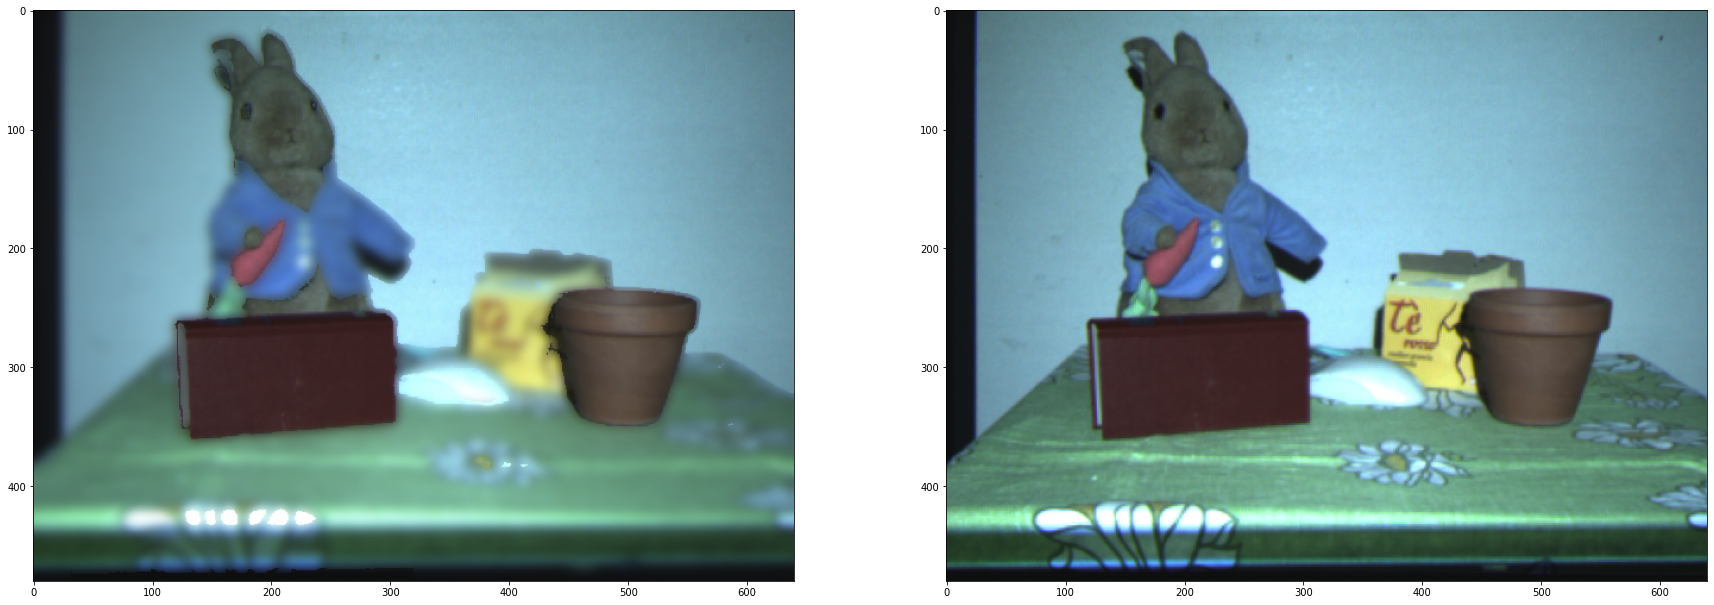

In [15]:
stereo_blur(rabbit_bilateral, rabbit_ref, 160, 230)

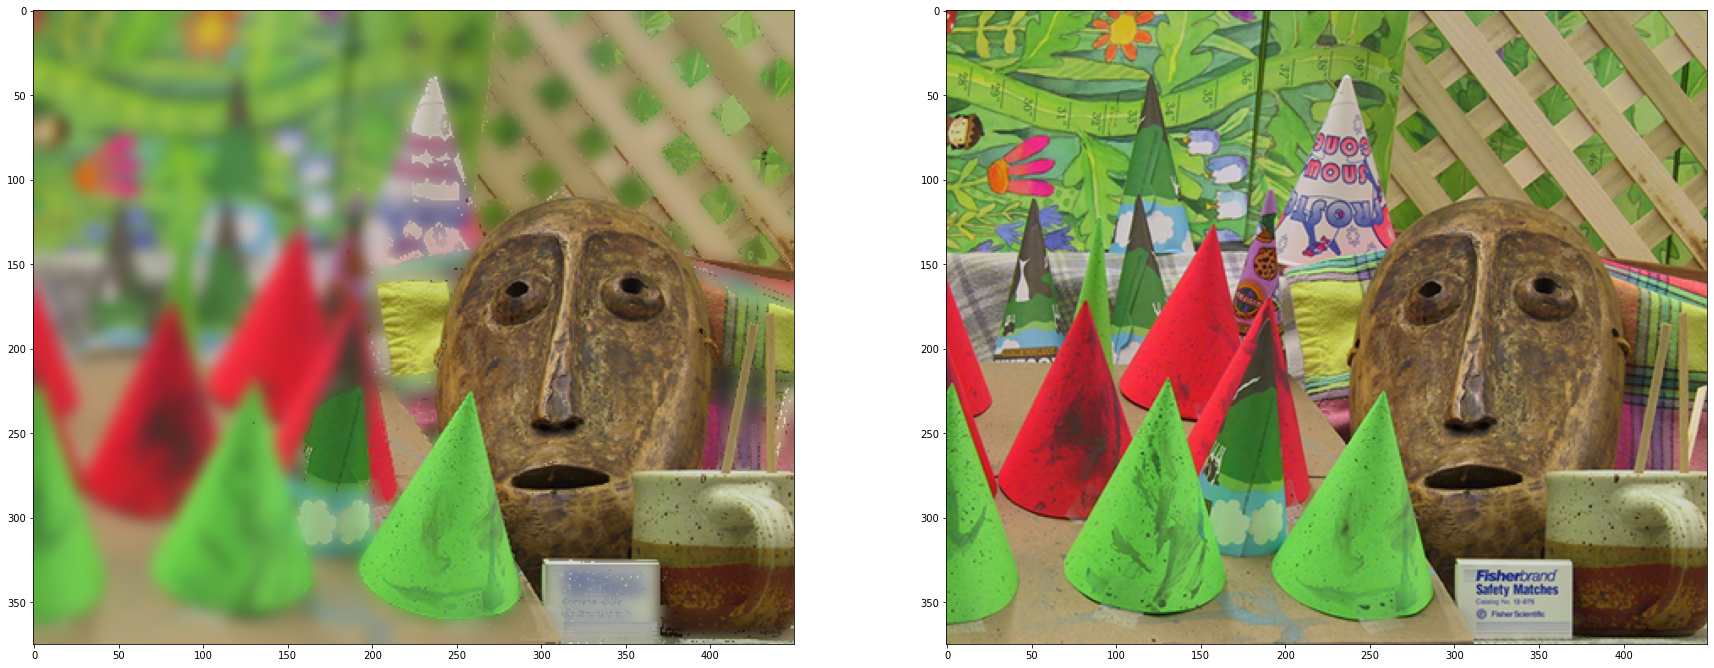

In [16]:
stereo_blur(cones_bilateral, cones_ref, 108, 150)

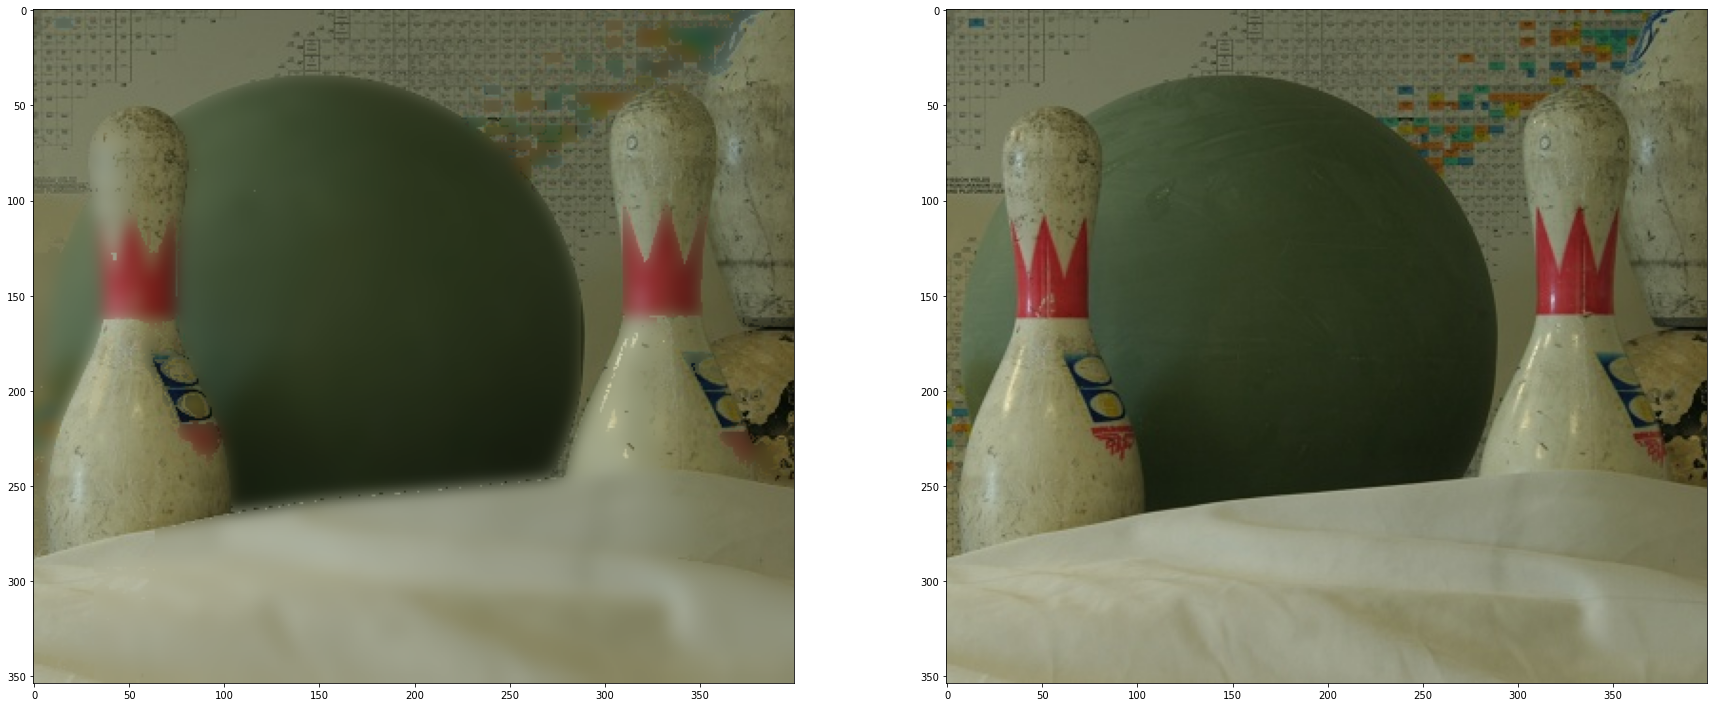

In [17]:
stereo_blur(pin_bilateral, pin_ref, 180, 220)